# XOR: backprop keras para MLP BinaryCrossEntropy

MLP con una capa oculta, afinidad-ReLU, seguida de una capa de salida con sigmoide para entrenamiento con entropía cruzada binaria (y clasificación binaria MAP posterior):
$$\begin{align*}
\boldsymbol{x}&=(x_1,x_2)\in\{0, 1\}^n%
&&\text{donde}\quad n=2\\%
\boldsymbol{z}&=\mathbf{W}\boldsymbol{x}+\boldsymbol{b}_1\in\mathbb{R}^{m_1}%
&&\text{donde}\quad m_1=2,\,\mathbf{W}\in\mathbb{R}^{m_1\times n}\;\text{y}\;\boldsymbol{b}_1\in\mathbb{R}^{m_1}\\%
\boldsymbol{h}&=\operatorname{ReLU}(\boldsymbol{z})\in\mathbb{R}^{m_2}%
&&\text{donde}\quad m_2=2\\%
a&=\mathbf{V}\boldsymbol{h}+b_2\in\mathbb{R}^{m_3}%
&&\text{donde}\quad m_3=1,\,\mathbf{V}\in\mathbb{R}^{m_3\times m_2}\;\text{y}\;b_2\in\mathbb{R}^{m_3}\\%
\hat{y}&=\sigma(a)\in[0,1]%
&&\text{probabilidad de la clase 1}\\%
\mathcal{L}&=\operatorname{BinaryCrossEntropy}(y,\hat{y})\in\mathbb{R}%
&&\text{salida escalar}\quad m=1%
\end{align*}$$

**Producto vector-Jacobiana (VJP):** $\qquad\boldsymbol{u}^t\mathbf{J}_{\mathcal{L}}(\boldsymbol{x})=\underbrace{\boldsymbol{u}^t}_{1\times m}\underbrace{\mathbf{J}_{\mathcal{L}}(\hat{y})}_{m\times m_3}\underbrace{\mathbf{J}_{\hat{y}}(a)}_{m_3\times m_3}\underbrace{\mathbf{J}_{a}(\boldsymbol{h})}_{m_3\times m_2}\underbrace{\mathbf{J}_{\boldsymbol{h}}(\boldsymbol{z})}_{m_2\times m_1}\underbrace{\mathbf{J}_{\boldsymbol{z}}(\boldsymbol{x})}_{m_1\times n}\in\mathbb{R}^{1\times n}$

## Modelo inicial
$$\quad\mathbf{W}=\begin{pmatrix}1&1\\1&1\end{pmatrix}\quad \boldsymbol{b}_1=\begin{pmatrix}0\\-1\end{pmatrix}\quad \mathbf{V}=\begin{pmatrix}1&-1\end{pmatrix}\quad b_2=0$$

In [3]:
import numpy as np; np.set_printoptions(precision=4); import matplotlib.pyplot as plt
import tensorflow as tf; from tensorflow import keras
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]) # probs
W = tf.constant_initializer([[1, 1], [1, 1]]); b1 = tf.constant_initializer([0,  -1])
V = tf.constant_initializer([[1], [-1]]); b2 = tf.constant_initializer([0])
L1 = keras.layers.Dense(2, activation=tf.nn.relu, input_dim=2, kernel_initializer=W, bias_initializer=b1)
L2 = keras.layers.Dense(1, activation=tf.nn.sigmoid, kernel_initializer=V, bias_initializer=b2)
M = keras.Sequential([L1, L2]); M.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 9 (36.00 Byte)
Trainable params: 9 (36.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Entrenamiento

[array([[1., 1.],
       [1., 1.]], dtype=float32), array([ 0., -1.], dtype=float32)] 
 [array([[ 1.],
       [-1.]], dtype=float32), array([0.], dtype=float32)]
1/1 [==============================] - 0s 338ms/step - loss: 0.6582
[array([[0.9134, 1.1371],
       [0.9134, 1.1371]], dtype=float32), array([-0.0362, -0.8629], dtype=float32)] 
 [array([[ 0.8267],
       [-1.1371]], dtype=float32), array([-0.13], dtype=float32)]
1/1 [==============================] - 0s 4ms/step - loss: 0.5818
[array([[0.9122, 1.1386],
       [0.9122, 1.1386]], dtype=float32), array([ 0.0293, -0.953 ], dtype=float32)] 
 [array([[ 0.8214],
       [-1.2085]], dtype=float32), array([-0.1384], dtype=float32)]
1/1 [==============================] - 0s 4ms/step - loss: 0.5615


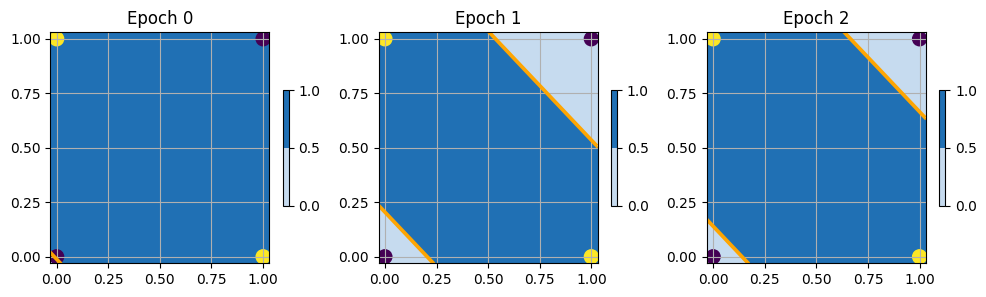

In [4]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.optimizers.SGD(learning_rate=0.75)
M.compile(loss=loss, optimizer=optimizer)
nrows = 1; ncols = 3; epochs = nrows * ncols
x1, x2 = np.meshgrid(np.linspace(-.03, 1.03, 50), np.linspace(-.03, 1.03, 50))
XX = np.c_[np.ravel(x1), np.ravel(x2)]
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3*nrows))
for epoch in np.arange(epochs):
    print(L1.get_weights(), "\n", L2.get_weights());
    ax = axes.flat[epoch]; ax.set_title(f'Epoch {epoch}'); ax.grid();
    ticks = [.0, .25, .5, .75, 1.]; ax.set_xticks(ticks); ax.set_yticks(ticks)
    yy = np.heaviside(M.predict(XX, verbose=0) - 0.5, 0.0)
    ax.contour(x1, x2, yy.reshape(x1.shape), 1, colors='orange', linestyles='solid')
    cp = ax.contourf(x1, x2, yy.reshape(x1.shape), 1, cmap='Blues')
    plt.colorbar(cp, ax=ax, shrink=0.5)
    ax.scatter(*X.T, c=y, s=100)
    M.fit(X, y, epochs=1, verbose=1);